## 1.计算

In [5]:
import pandas as pd
import pickle
import numpy as np
import warnings
from sklearn.exceptions import InconsistentVersionWarning
from sklearn.preprocessing import StandardScaler  # 导入 StandardScaler

# 忽略 sklearn 版本不一致的警告
warnings.filterwarnings("ignore", category=InconsistentVersionWarning)

# -------------------------------
# 1. 加载模型与数据

# 加载经过 Platt Scaling 校准的最优分类器模型（CalibratedClassifierCV 对象）
with open('metrics/best_model_item.pkl', 'rb') as file:
    best_model_item = pickle.load(file)
best_clf = best_model_item['clf']

# 读取数据集B，并按组别划分
data_b = pd.read_excel('data-B.xlsx')
cognitive_group = data_b[data_b['group'] == 1].copy()
simple_group = data_b[data_b['group'] == 2].copy()
control_group = data_b[data_b['group'] == 3].copy()

# 定义执行功能相关的特征名称（不含 _pre/_post 后缀）
exec_features = [
    'rm_1750_acc', 'rm_750_acc', 'dsbt_span',
    'stroop_incongruent_rt', 'stroop_interference_effect_rt',
    'nogo_acc', 'switch_cost'
]

def predict_probabilities(group):
    """
    对单个组的数据，利用校准模型预测 pre 与 post 时刻的分类概率。
    数据预处理采用先将 pre 与 post 数据合并拟合 StandardScaler，然后分别转换。
    """
    # 构造 pre 与 post 的特征名称
    pre_features = [f + '_pre' for f in exec_features]
    post_features = [f + '_post' for f in exec_features]
    
    # 检查数据中是否存在这些特征列
    pre_features = [f for f in pre_features if f in group.columns]
    post_features = [f for f in post_features if f in group.columns]
    
    if not pre_features or not post_features:
        raise ValueError("数据集中没有找到所需的特征列")
    
    # 提取 pre 与 post 的数据（转换为 numpy 数组）
    X_pre = group[pre_features].to_numpy()
    X_post = group[post_features].to_numpy()
    
    # -------------------------------
    # 分别标准化处理：先合并数据拟合 StandardScaler，然后分别转换
    scaler = StandardScaler()
    X_combined = np.vstack([X_pre, X_post])
    scaler.fit(X_combined)
    X_pre_scaled = scaler.transform(X_pre)
    X_post_scaled = scaler.transform(X_post)
    
    # 利用模型计算概率
    prob_pre = best_clf.predict_proba(X_pre_scaled)[:, 0]
    prob_post = best_clf.predict_proba(X_post_scaled)[:, 0]
    
    return prob_pre, prob_post

# -------------------------------
# 2. 对各组数据进行概率预测

cognitive_prob_pre, cognitive_prob_post = predict_probabilities(cognitive_group)
simple_prob_pre, simple_prob_post = predict_probabilities(simple_group)
control_prob_pre, control_prob_post = predict_probabilities(control_group)

# 将预测结果写入各组 DataFrame，并计算变化分数
for group, prob_pre, prob_post in zip(
    [cognitive_group, simple_group, control_group],
    [cognitive_prob_pre, simple_prob_pre, control_prob_pre],
    [cognitive_prob_post, simple_prob_post, control_prob_post]
):
    group['prob_pre'] = prob_pre
    group['prob_post'] = prob_post
    group['prob_change'] = prob_post - prob_pre

# 输出各组的均值（便于检查）
print("各组的概率变化均值：")
print(f"认知训练组： mean(prob_change) = {np.mean(cognitive_group['prob_change']):.4f}")
print(f"简单反应组： mean(prob_change) = {np.mean(simple_group['prob_change']):.4f}")
print(f"对照组： mean(prob_change) = {np.mean(control_group['prob_change']):.4f}")

print("\n各组前后测的概率均值：")
print(f"认知训练组： mean(prob_pre) = {np.mean(cognitive_group['prob_pre']):.4f}, mean(prob_post) = {np.mean(cognitive_group['prob_post']):.4f}")
print(f"简单反应组： mean(prob_pre) = {np.mean(simple_group['prob_pre']):.4f}, mean(prob_post) = {np.mean(simple_group['prob_post']):.4f}")
print(f"对照组： mean(prob_pre) = {np.mean(control_group['prob_pre']):.4f}, mean(prob_post) = {np.mean(control_group['prob_post']):.4f}")

# -------------------------------
# 3. 保存结果到 Excel 文件
output_cols = ['id', 'prob_pre', 'prob_post', 'prob_change']

# 四舍五入到三位小数后再保存
cognitive_group[output_cols] = cognitive_group[output_cols].round(4)
simple_group[output_cols] = simple_group[output_cols].round(4)
control_group[output_cols] = control_group[output_cols].round(4)

cognitive_group[output_cols].to_excel('./table/Cognitive_Group_Probabilities.xlsx', index=False)
simple_group[output_cols].to_excel('./table/Simple_Group_Probabilities.xlsx', index=False)
control_group[output_cols].to_excel('./table/Control_Group_Probabilities.xlsx', index=False)

print("\n概率预测结果已保存到 Excel 文件（保留三位小数）")

各组的概率变化均值：
认知训练组： mean(prob_change) = -0.0168
简单反应组： mean(prob_change) = 0.0117
对照组： mean(prob_change) = 0.0080

各组前后测的概率均值：
认知训练组： mean(prob_pre) = 0.4644, mean(prob_post) = 0.4476
简单反应组： mean(prob_pre) = 0.4240, mean(prob_post) = 0.4357
对照组： mean(prob_pre) = 0.4264, mean(prob_post) = 0.4345

概率预测结果已保存到 Excel 文件（保留三位小数）


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

# -------------------------------
# 1. 重新读取保存的 Excel 文件

cognitive_df = pd.read_excel('./table/Cognitive_Group_Probabilities的副本.xlsx')
simple_df = pd.read_excel('./table/Simple_Group_Probabilities的副本.xlsx')
control_df = pd.read_excel('./table/Control_Group_Probabilities的副本.xlsx')

# 为每个 DataFrame 添加组别标签
cognitive_df['group'] = 'Cognitive'
simple_df['group'] = 'Simple'
control_df['group'] = 'Control'

# 合并所有组的数据
all_groups = pd.concat([cognitive_df, simple_df, control_df], ignore_index=True)

# -------------------------------
# 2. 数据转换为长格式，便于绘图和描述统计
# 每个被试会有两行数据：一行为 pre，一行为 post
data_long = pd.melt(
    all_groups,
    id_vars=['id', 'group'],
    value_vars=['prob_pre', 'prob_post'],
    var_name='time',
    value_name='probability'
)
# 将 time 标签替换为更易理解的名称
data_long['time'] = data_long['time'].str.replace('prob_', '')
data_long['time'] = data_long['time'].replace({'pre': 'Pre-test', 'post': 'Post-test'})

# -------------------------------
# 3. 描述统计（三线表格式：均值 ± 标准差 (n)）

# 计算各组各时间点的均值、标准差和样本量
desc_stats = data_long.groupby(['group', 'time'])['probability'].agg(['mean', 'std', 'count']).reset_index()

# 构造显示“均值 ± 标准差 (n)”的列
desc_stats['Mean ± SD (n)'] = desc_stats.apply(
    lambda row: f"{row['mean']:.4f} ± {row['std']:.4f} (n={int(row['count'])})", axis=1)

# 打印三线表（仅文本格式）
line = "-" * 50
print(line)
print("{:<12}{:<12}{:<30}".format("Group", "Time", "Mean ± SD (n)"))
print(line)
for index, row in desc_stats.iterrows():
    print("{:<12}{:<12}{:<30}".format(row['group'], row['time'], row['Mean ± SD (n)']))
print(line)

# -------------------------------
# 5. GLM 分析及事后检验

# 构建 GLM 模型：公式中将 group 与 time 均作为分类变量，关注其交互作用
model_prob = smf.ols('probability ~ C(group) * C(time)', data=data_long).fit()
print("\nGLM 分析 —— 分类概率（组别 * 时间点）")
print(model_prob.summary())

# 利用 Type II ANOVA 查看各因素及交互项的显著性
anova_prob = sm.stats.anova_lm(model_prob, typ=2)
print("\nANOVA（分类概率）：")
print(anova_prob)

# -------------------------------
# 交互作用显著时进行事后检验
# 检查交互作用的 p 值
interaction_p = anova_prob.loc['C(group):C(time)', 'PR(>F)']
if interaction_p < 0.05:
    print("\n交互作用显著 (p = {:.4f})，进行事后检验...".format(interaction_p))
    # 为事后检验构造组合变量（组别和时间点的交互组合）
    data_long['group_time'] = data_long['group'] + "_" + data_long['time']
    
    from statsmodels.stats.multicomp import pairwise_tukeyhsd
    tukey_results = pairwise_tukeyhsd(
        endog=data_long['probability'],
        groups=data_long['group_time'],
        alpha=0.05
    )
    print("\nTukey HSD 事后检验结果：")
    print(tukey_results.summary())
else:
    print("\n交互作用不显著 (p = {:.4f})，不进行事后检验。".format(interaction_p))

--------------------------------------------------
Group       Time        Mean ± SD (n)                 
--------------------------------------------------
Cognitive   Post-test   0.3879 ± 0.2047 (n=32)        
Cognitive   Pre-test    0.1321 ± 0.1858 (n=32)        
Control     Post-test   0.1413 ± 0.1291 (n=29)        
Control     Pre-test    0.1512 ± 0.1330 (n=29)        
Simple      Post-test   0.2196 ± 0.1507 (n=33)        
Simple      Pre-test    0.1498 ± 0.1268 (n=33)        
--------------------------------------------------

GLM 分析 —— 分类概率（组别 * 时间点）
                            OLS Regression Results                            
Dep. Variable:            probability   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     12.28
Date:                Fri, 14 Feb 2025   Prob (F-statistic):           2.89e-10
Time:                        22:29:57   L

## 2.可视化

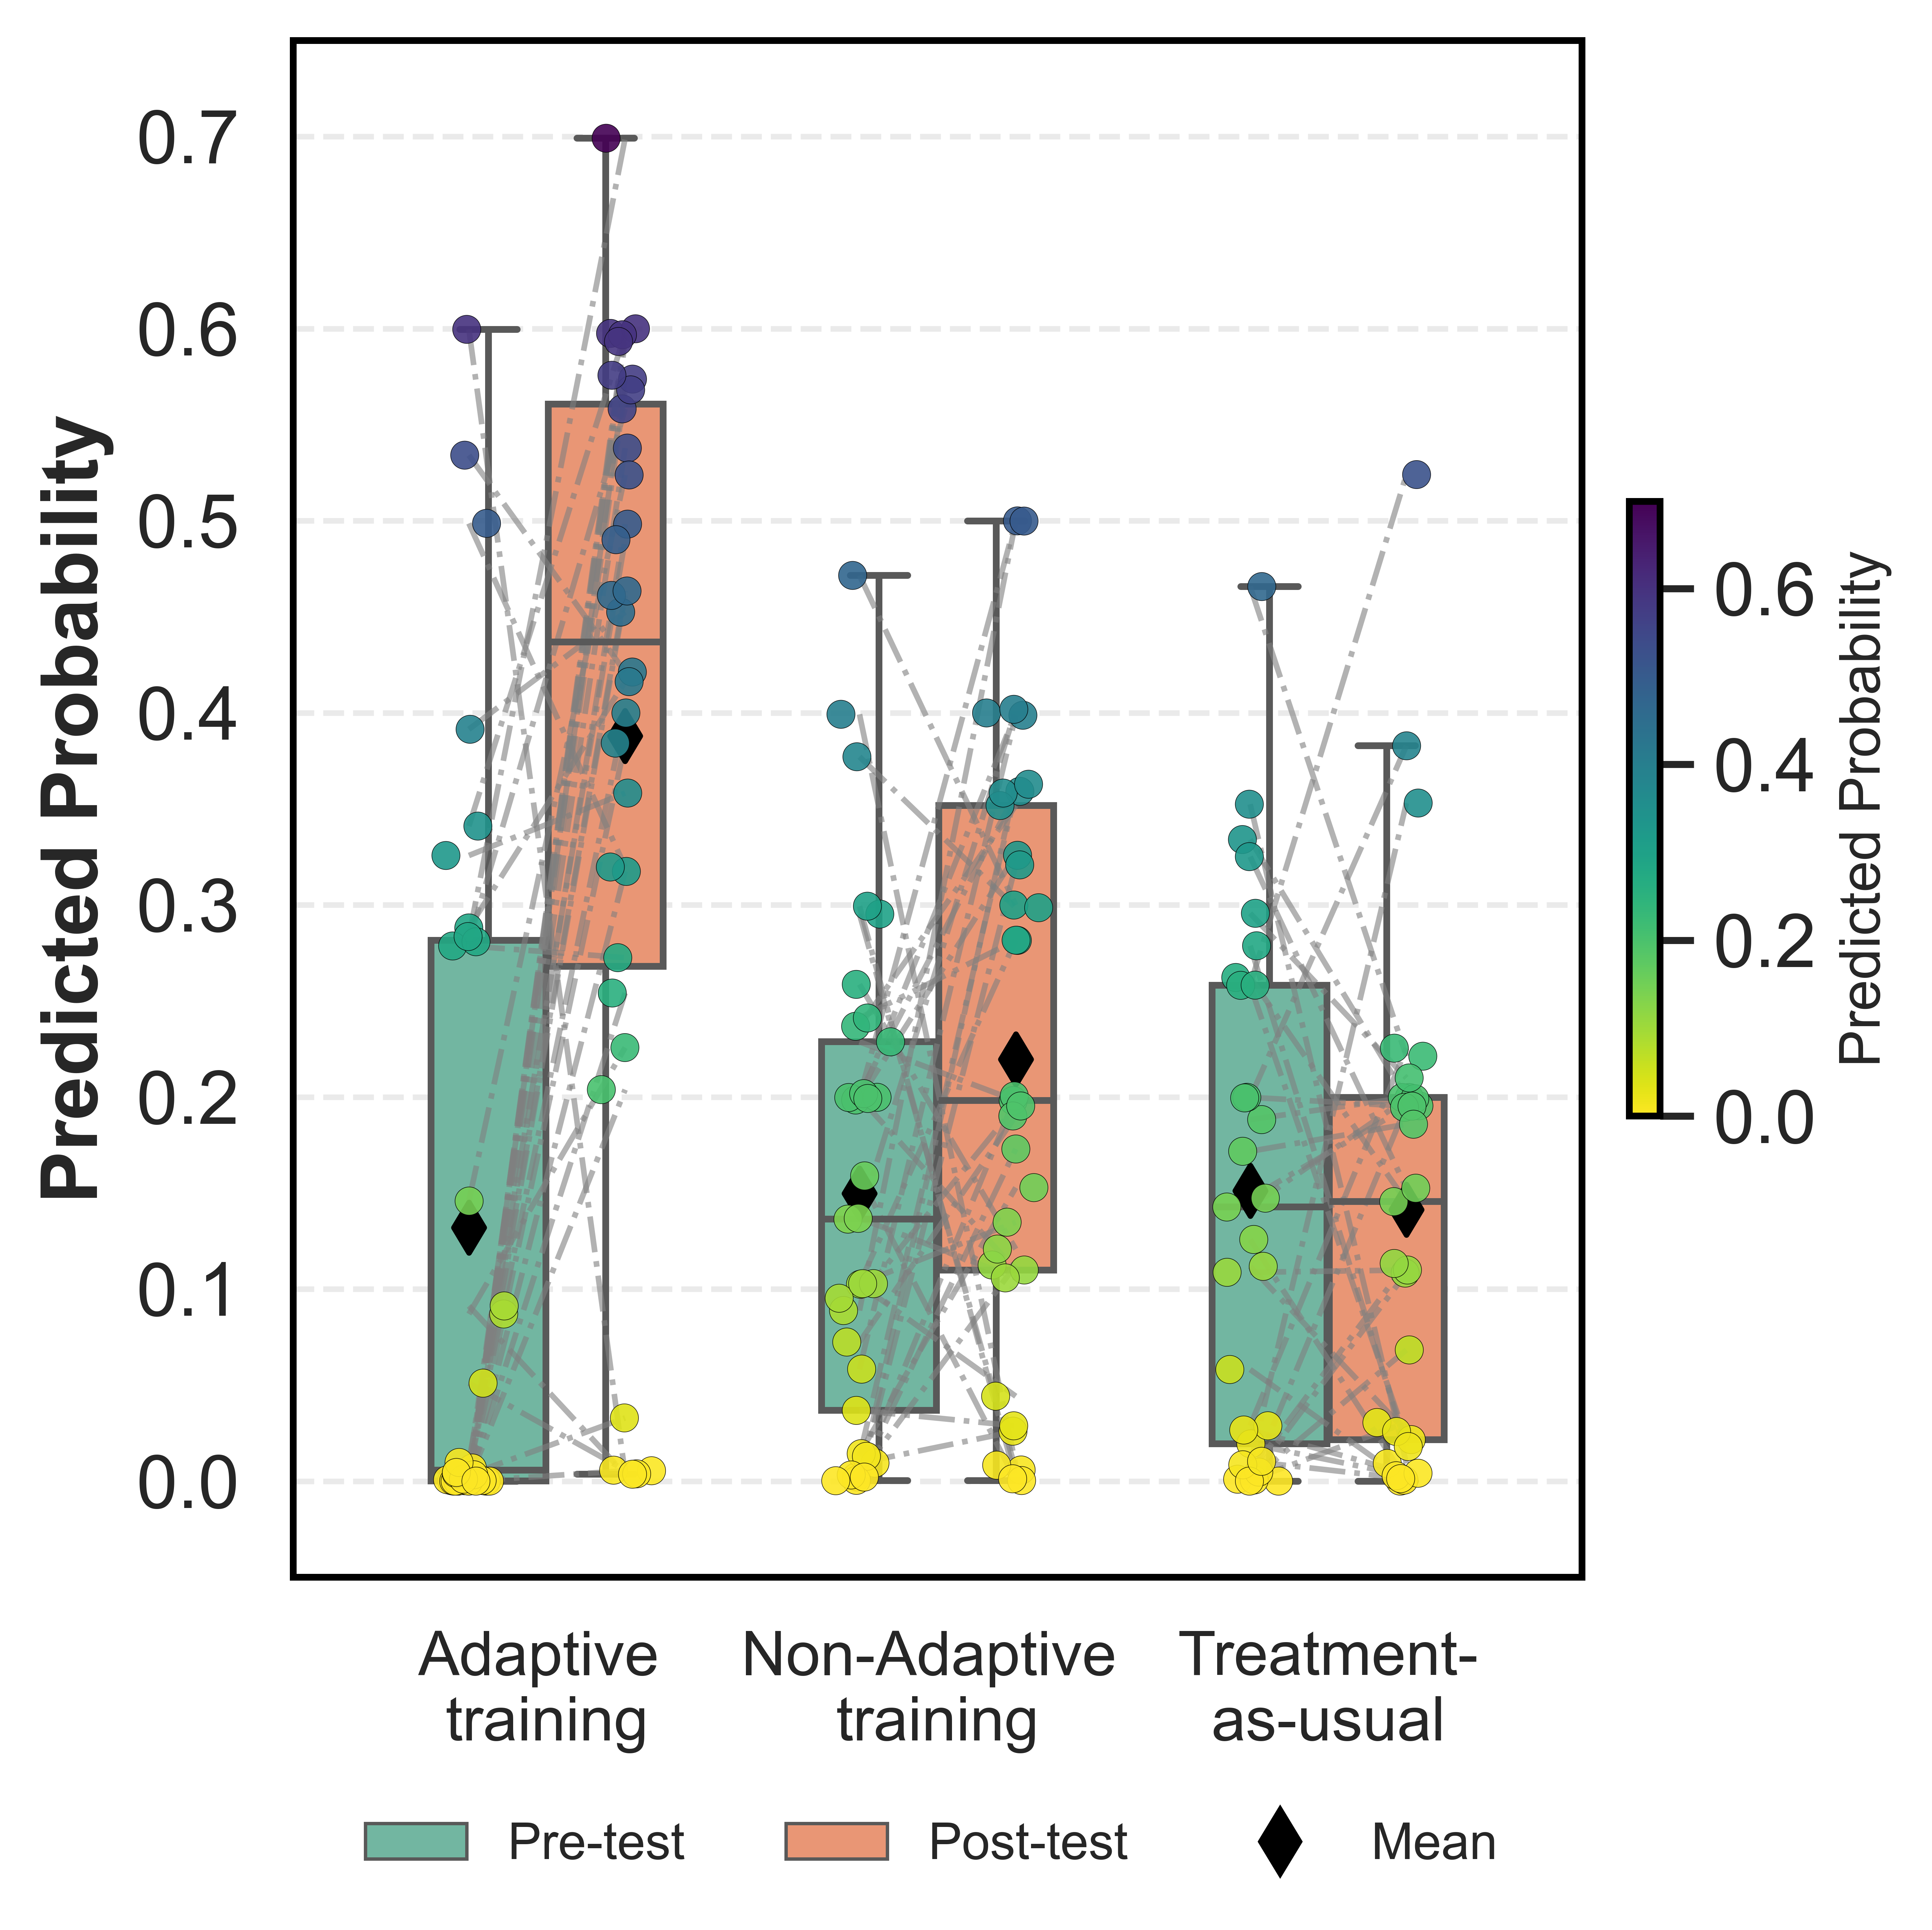

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.cm import ScalarMappable

# -------------------------------
# 1. 重新读取保存的 Excel 文件
cognitive_df = pd.read_excel('./table/Cognitive_Group_Probabilities的副本.xlsx')
simple_df = pd.read_excel('./table/Simple_Group_Probabilities的副本.xlsx')
control_df = pd.read_excel('./table/Control_Group_Probabilities的副本.xlsx')

# 为每个 DataFrame 添加组别标签
cognitive_df['Group'] = 'Adaptive \ntraining'
simple_df['Group'] = 'Non-Adaptive \ntraining'
control_df['Group'] = 'Treatment-\nas-usual'

# 合并所有组的数据
data = pd.concat([cognitive_df, simple_df, control_df], ignore_index=True)

# -------------------------------
# 2. 数据转换为长格式，便于绘图和描述统计
# 每个被试会有两行数据：一行为 pre，一行为 post
data_melted = pd.melt(data, id_vars=['id', 'Group'], value_vars=['prob_pre', 'prob_post'],
                      var_name='Time', value_name='Probability')
data_melted['Time'] = data_melted['Time'].replace({'prob_pre': 'Pre-test', 'prob_post': 'Post-test'})

# -------------------------------
# 3. 绘图设置
sns.set(style="whitegrid", font="Arial", font_scale=1.2)
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['axes.edgecolor'] = 'black'

plt.figure(figsize=(5, 5), dpi=1200)
ax = sns.boxplot(x='Group', y='Probability', hue='Time', data=data_melted, palette='Set2',
                 showfliers=False, width=0.6, linewidth=1.2)

# 调整 X 轴刻度标签字体大小
ax.tick_params(axis='x', labelsize=11)

# 创建颜色映射
cmap = plt.get_cmap('viridis_r')
norm = plt.Normalize(data_melted['Probability'].min(), data_melted['Probability'].max())

# 生成组别映射，使用原始的组别标签
group_order = ['Adaptive \ntraining', 'Non-Adaptive \ntraining', 'Treatment-\nas-usual']
group_codes = {group: idx for idx, group in enumerate(group_order)}

# 绘制散点（带颜色映射）
for (group, time), subset in data_melted.groupby(['Group', 'Time']):
    # 计算基础X坐标
    base_x = group_codes[group]
    # 根据时间类型设置偏移量
    x_offset = -0.2 if time == 'Pre-test' else 0.2
    # 添加随机抖动
    jitter = np.random.normal(0, 0.03, size=len(subset))
    # 计算最终坐标
    x = base_x + x_offset + jitter
    # 绘制散点
    ax.scatter(x, subset['Probability'], c=subset['Probability'], cmap='viridis_r', 
               norm=norm, s=25, edgecolor='black', linewidth=0.1, alpha=0.9, zorder=10)

# 添加颜色条（纵向放置）
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical',
                    shrink=0.4,   # 调整颜色条整体长度
                    pad=0.03,     # 调整颜色条与图像之间的距离
                    aspect=20)    # 数值越大颜色条越细
cbar.set_label('Predicted Probability', fontsize=10)

# 添加个体连线（每个被试的 pre 与 post 连线）
for group in group_order:
    subset = data_melted[data_melted['Group'] == group]
    for subject_id, subject_data in subset.groupby('id'):
        if len(subject_data) == 2:
            pre_value = subject_data[subject_data['Time'] == 'Pre-test']['Probability'].values[0]
            post_value = subject_data[subject_data['Time'] == 'Post-test']['Probability'].values[0]
            x_pre = group_codes[group] - 0.2
            x_post = group_codes[group] + 0.2
            plt.plot([x_pre, x_post], [pre_value, post_value], 
                     color='gray', alpha=0.6, lw=1, linestyle='-.')

# 绘制均值标记
means = data_melted.groupby(['Group', 'Time'])['Probability'].mean().unstack()
for group in group_order:
    idx = group_codes[group]
    ax.scatter(idx-0.2, means.loc[group, 'Pre-test'], 
               color='black', marker='d', s=40, zorder=8)
    ax.scatter(idx+0.2, means.loc[group, 'Post-test'], 
               color='black', marker='d', s=40, zorder=8)

# 设置坐标轴和标签
ax.set_xlabel("")
ax.set_ylabel("Predicted Probability", fontsize=14, weight='bold')

# 调整Y轴范围和刻度：设置范围为 -0.05 到 0.75，每隔 0.1 一个刻度
ax.set_ylim(-0.05, 0.75)
ax.set_yticks(np.arange(0, 0.75 + 0.001, 0.1))

# 调整图例
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2] + [plt.Line2D([0], [0], marker='d', color='black', 
                                  linestyle='', markersize=8)],
        ['Pre-test', 'Post-test', 'Mean'], 
        fontsize=9, frameon=False, 
        bbox_to_anchor=(0.97, -0.13), 
        ncol=3)

# 调整网格线
ax.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.savefig("./image/Group_Comparison_Pre_Post_Boxplot_Probability-.jpg", dpi=1200, format="jpg")
plt.show()

## 全部完成


In [4]:
print('全部完成！')

全部完成！
